In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/pca_joint')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 8

# Load data

In [2]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

## Scale Inputs

In [3]:

# # concat flows
# scaled_flows = list(flows_dict.values())
# scaled_flows = pd.concat(scaled_flows, axis=0)

# # scaler = MinMaxScaler((-1,1))
# scaler = RobustScaler()
# scaler.fit(scaled_flows)
# scaled_flows = scaler.transform(scaled_flows)

# scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
# print(scaled_flows.shape)
# print(scaled_flows.head())

In [4]:
# concat flows
scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler = QuantileTransformer()
scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.971481     0.681978
1  0.002002  0.971471     0.681745
2  0.004895  0.971462     0.681456
3  0.006006  0.971452     0.681141
4  0.008008  0.971442     0.680821


# All Columns

In [5]:
# separate into file series
scaled_all = [scaled_flows.iloc[i*640:i*640+640, :] for i in range(len(scaled_flows) // 640)]
scaled_all = [flow.values for flow in scaled_all]
scaled_all = np.array([flow.ravel() for flow in np.array(scaled_all)])
scaled_all.shape

(11771, 1920)

In [6]:
scaled_all[0][:20]

array([0.        , 0.97148134, 0.68197832, 0.00200202, 0.97147148,
       0.68174533, 0.00489512, 0.97146159, 0.68145583, 0.00600602,
       0.97145168, 0.68114129, 0.00800801, 0.97144174, 0.68082063,
       0.00900902, 0.97143177, 0.68058279, 0.01001005, 0.97142179])

## TSNE

In [7]:
tsne = TSNE(n_components=2)
transformed_all = tsne.fit_transform(scaled_all)
transformed_all.shape

(11771, 2)

<AxesSubplot: >

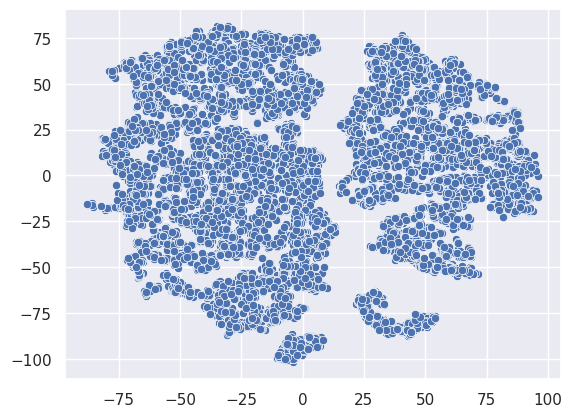

In [8]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

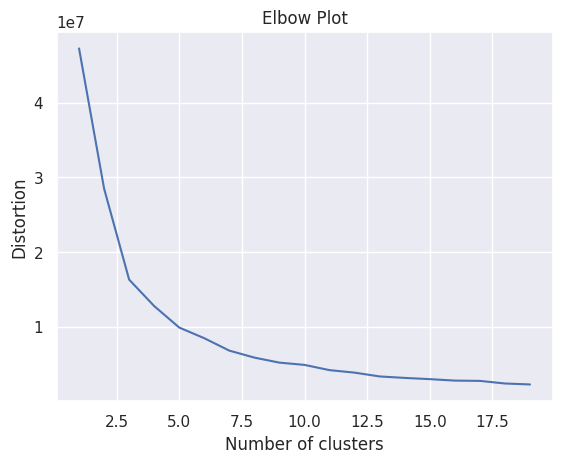

In [9]:
# Elbow Test
distortions = []
K = range(1, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_all)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')

In [10]:
kmeans = KMeans(n_clusters=9,max_iter=500, n_init='auto')
pca_kmeans_labels = kmeans.fit_predict(scaled_all)
nclusters = len(set(pca_kmeans_labels))

<AxesSubplot: >

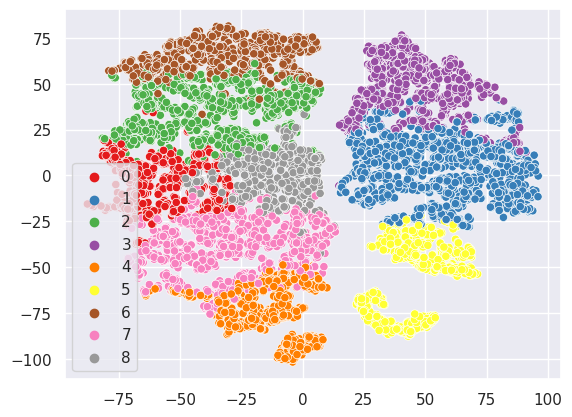

In [11]:
sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=pca_kmeans_labels, palette='Set1')

### Original Data

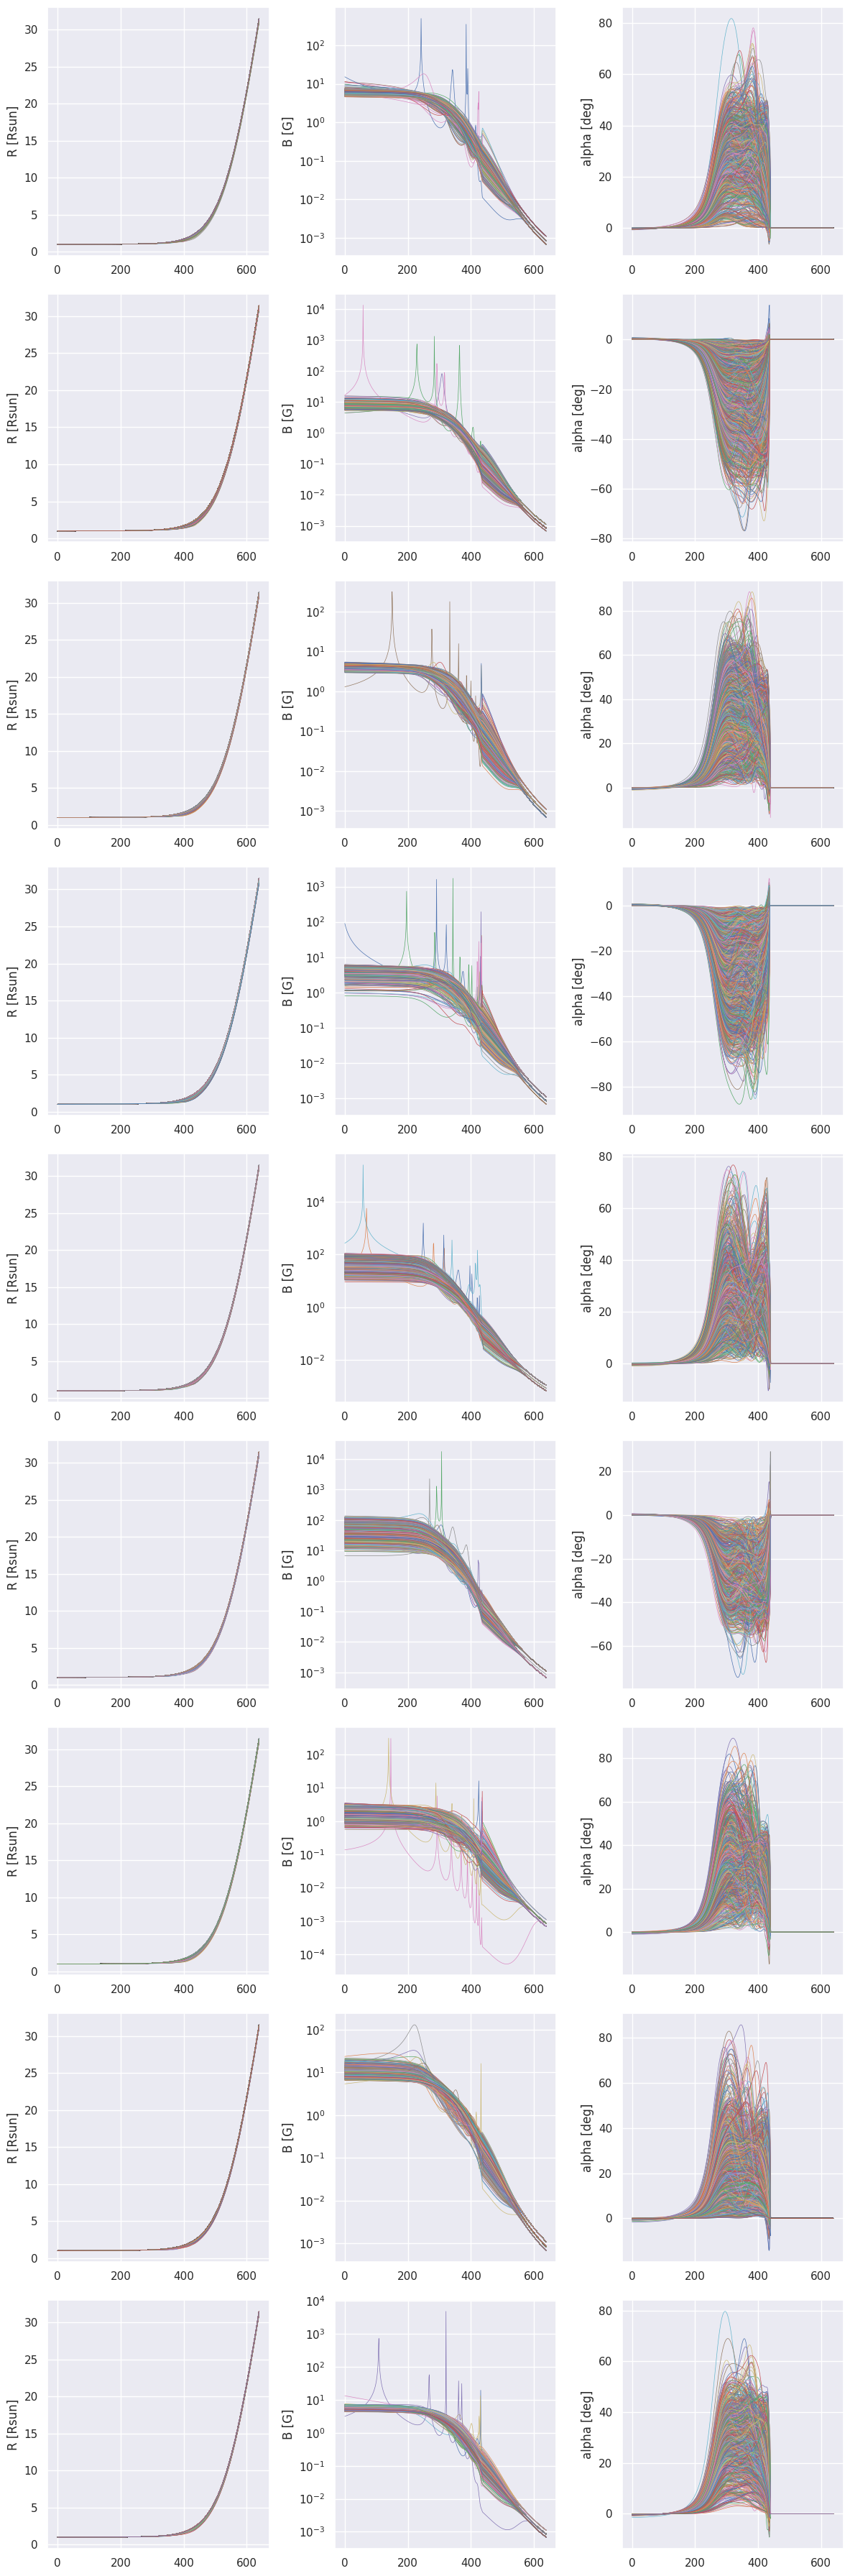

In [12]:
plot_unscaled_clusters(pca_kmeans_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

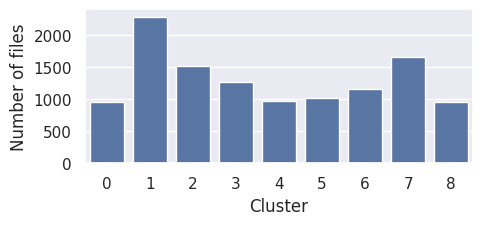

In [13]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

### Grid Search

In [14]:
# %%capture
# subdir = OUT_DIR / 'kmeans'
# if not subdir.exists():
#     subdir.mkdir(parents=True)
    
# for k in range(2, 5):
#     kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
#     kmeans_labels = kmeans.fit_predict(transformed_all)
    
#     sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=kmeans_labels, palette='Set1')
#     plt.savefig(subdir / f'scatter_{k}.png', dpi=200)
#     plot_unscaled_clusters(kmeans_labels, k, flows_dict, flow_columns, save_path=subdir / f'unscaled_{k}.png', yscale={'B [G]': 'log'})

## Hierarchical Clustering

In [15]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=7, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_all)
nclusters = len(set(agg.labels_))

Text(0.5, 0, 'Number of points in node')

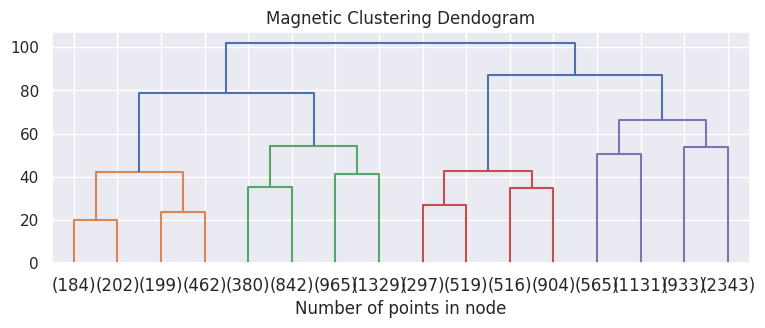

In [16]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

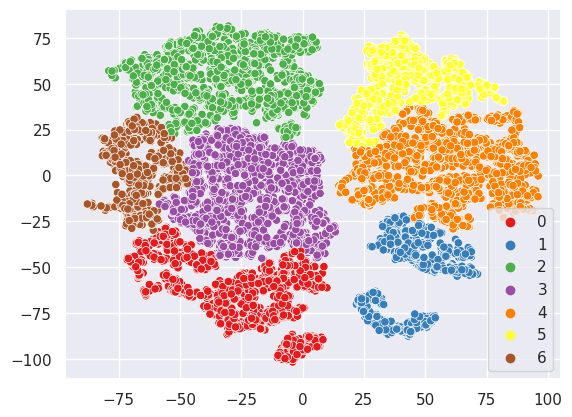

In [17]:
sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

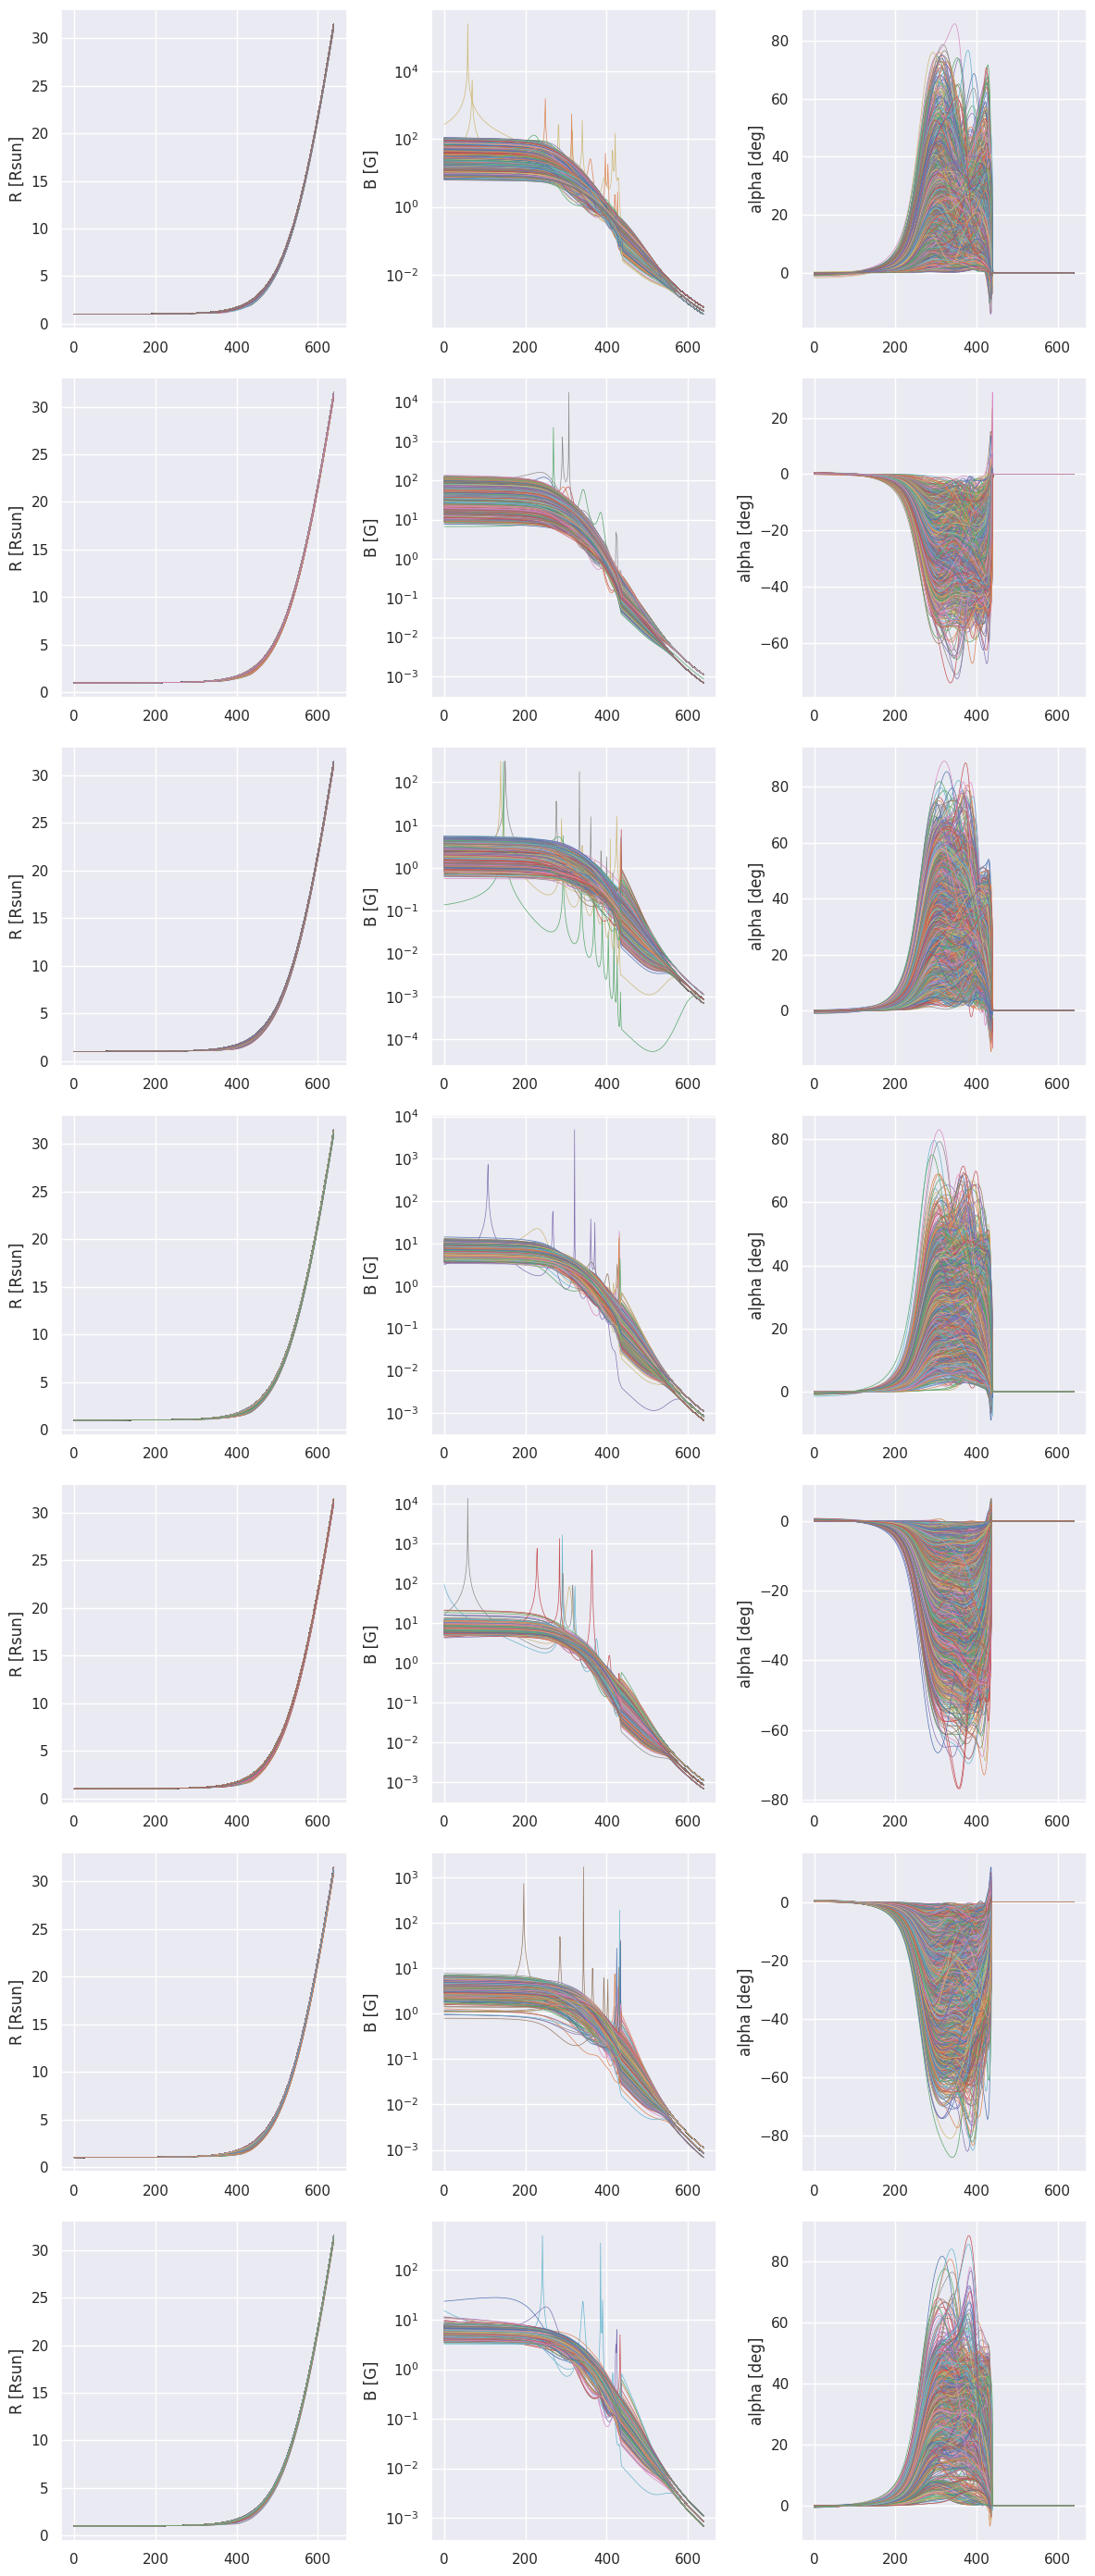

In [18]:
plot_unscaled_clusters(agg.labels_, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

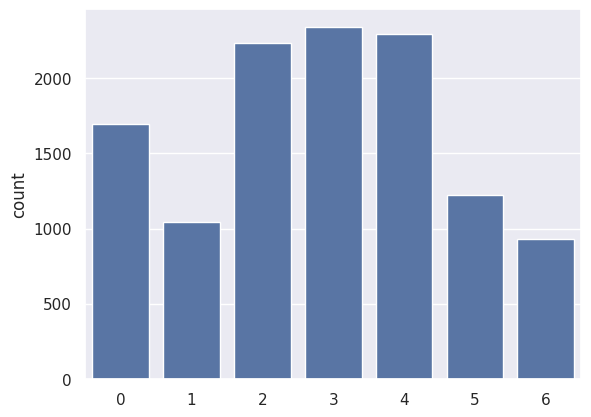

In [19]:
sns.countplot(x=agg.labels_, color='b')

### Grid Search

In [20]:
# %%capture
# sub_dir = OUT_DIR / 'hierarchical'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_all)
    
#     sp = sns.scatterplot(x=transformed_all[:, 0], y=transformed_all[:, 1], hue=agg.labels_, palette='Set1') 
#     plt.savefig(sub_dir / f'scatter_{i}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, i, flows_dict, flow_columns, save_path=sub_dir / f'unscaled_{i}.png', yscale={'B [G]': 'log'}) 
    